# Compare different lists of German law journals

We have the following lists:

1. Gold standard derived from Gröls/Gröls 2019 (53 entries, value)
2. Wikipedia Category "Juristische Fachzeitschrift (Deutschland)" (147 with value) 
3. Aggregation of internet lists (750)
4. ZDB DCC 340 + Language: German 1945-2024 (1692 entries)





Some housekeeping:

In [ ]:
%pip install --quiet wordcloud venny4py
%matplotlib inline

First, we create a matrix of intersections of ISSN numbers

In [45]:
import pandas as pd
import regex as re

def calculate_df_intersections(dataframes, column_name, separator=None, strip_chars_regex=None):
    unique_values = set()
    value_index_mapping = {}

    for df_index, df in enumerate(dataframes):
        for idx, row in df.iterrows():
            col_value = row.get(column_name)
            if pd.isna(col_value):
                continue
            values = [value.strip() for value in col_value.split(separator)] if separator else [col_value]
            for value in values:
                if strip_chars_regex is not None:
                    value = re.sub(strip_chars_regex, '', value)
                unique_values.add(value)
                # Store the index of the row in the mapping
                if value not in value_index_mapping:
                    value_index_mapping[value] = {}
                value_index_mapping[value][df_index] = idx
    
    # Create a lookup table with unique values
    value_lookup_table = pd.DataFrame(list(unique_values), columns=[column_name])
    
    # Add a column for each dataframe to the lookup table
    for df_index in range(len(dataframes)):
        col = f'df_{df_index}_index'
        value_lookup_table[col] = value_lookup_table[column_name].apply(
            lambda value: value_index_mapping.get(value, {}).get(df_index, None)
        )

    return value_lookup_table

# gold
df_1 = pd.read_csv('data/kb_data/jura_groels_alle_zeitschriften.csv')
df_1 = df_1[['zeitschrift', 'issn_list']].rename(columns={'zeitschrift': 'journal', 'issn_list': 'issn'})

# Wikipedia
df_2 = pd.read_csv('data/wikipedia/category-law-journal-germany-with-issn.csv')

# internet lists
df_3 = pd.read_csv('data/web_lists/juristische-zeitschriften-issn-berichtigt.csv')

# ZDB
df_4 = pd.read_csv('data/zdb/zdb-ger-law-issn-1945-2024.csv').rename(columns={'title': 'journal'})

df = calculate_df_intersections([df_1, df_2, df_3, df_4], 
                           column_name='issn', separator=',', strip_chars_regex=r'[-{}]')

df = df.rename(columns={'df_0_index': 'Gold', 'df_1_index': 'Wikipedia', 'df_2_index': 'Internet', 'df_3_index': 'ZDB' })

df['abbr'] = df['Internet'].apply(lambda x: df_3['abbreviation'][int(x)] if pd.notna(x) else None)

df.to_csv('data/comparisons/lists-issns.csv', index=None, float_format=lambda x: '%d' % x)


From this, we can create a 4-Set Venn diagram to get a visual overview on the intersections of ISSNs

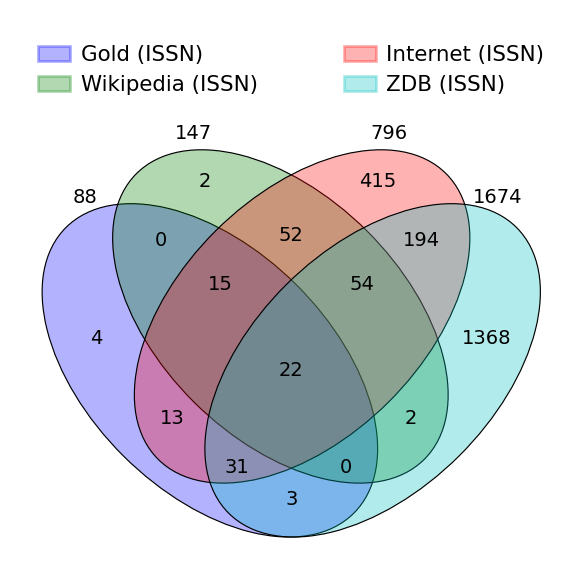

In [56]:
import numpy as np
import pandas as pd 
from venny4py.venny4py import venny4py 

df = pd.read_csv('data/comparisons/lists-issns.csv')

def create_issn_sets(df):
    result_dict = {}
    for column in df.columns[1:5]:
        non_nan_issn = df.loc[df[column].notna(), df.columns[0]].unique()
        result_dict[f'{column} (ISSN)'] = set(non_nan_issn)
    return result_dict

venny4py(sets=create_issn_sets(df), out="tmp")

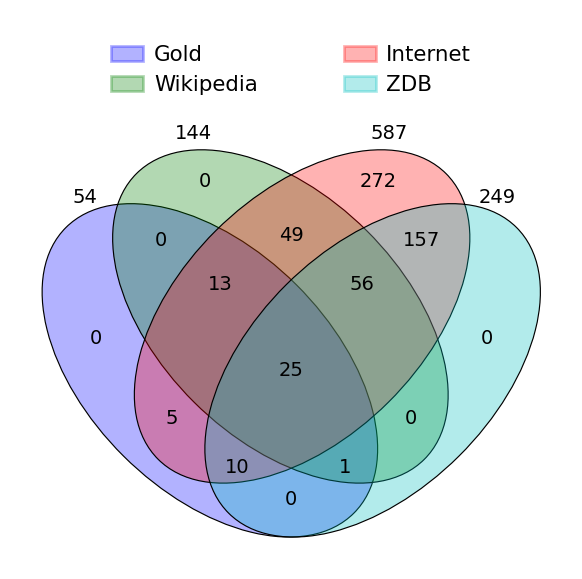

In [57]:
import numpy as np
import pandas as pd 
from venny4py.venny4py import venny4py 

df = pd.read_csv('data/comparisons/lists-issns.csv')

def create_abbr_sets(df):
    result_dict = {}
    for column in df.columns[1:5]:
        non_nan_abbr = df.loc[df[column].notna(), df.columns[5]].unique()
        result_dict[f'{column}'] = set(non_nan_abbr)
    return result_dict

venny4py(sets=create_abbr_sets(df), out="tmp")

To get a sense for which journals are in most lists, we create a word cloud where the size of the journal abbreviation corresponds to the number of sets in which the corresponding ISSN numbers are contained. 

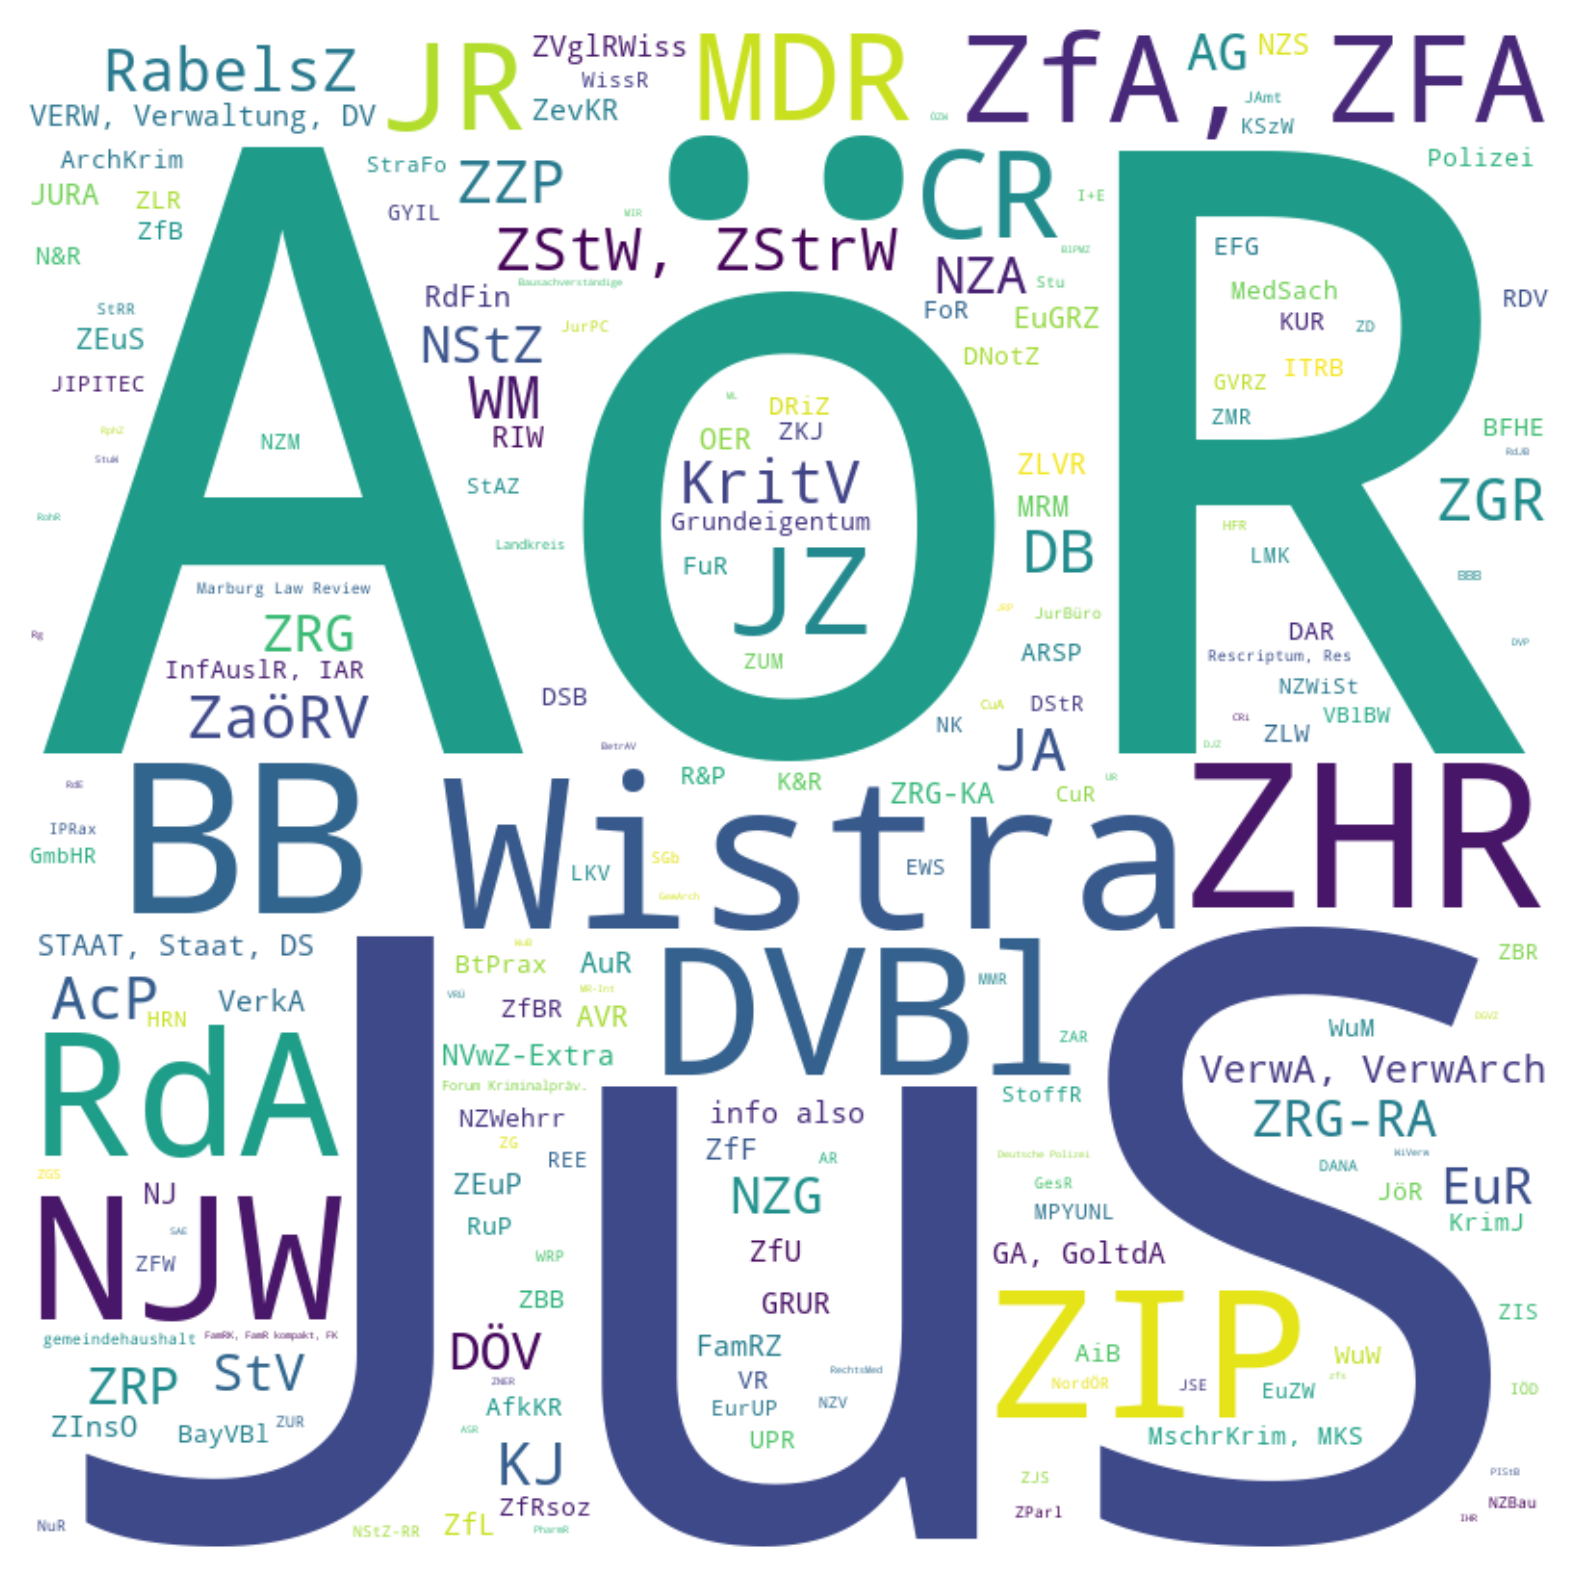

In [67]:
import numpy as np
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import defaultdict

# Load your DataFrame (make sure the path is correct)
df = pd.read_csv('data/comparisons/lists-issns.csv')

def create_abbr_sets(df):
    result_dict = {}
    for column in df.columns[1:5]:  # Adjust the range based on actual columns
        non_nan_abbr = df.loc[df[column].notna(), 'abbr'].unique()
        result_dict[f'{column}'] = set(non_nan_abbr)
    return result_dict

def create_word_cloud(data_dict):
    label_counts = defaultdict(int)

    # Count how many unique sets each label is associated with
    for key, label_set in data_dict.items():
        for label in label_set:
            if not pd.isna(label):
                label_counts[label] += 1

    # Filter out labels that have counts less than or equal to 1
    label_counts = {label: count for label, count in label_counts.items() if count > 1}

    # Create a circular word cloud
    wordcloud = WordCloud(width=800, height=800,
                          background_color='white',
                          collocations=False,
                          margin=10,
                          contour_color='black',
                          contour_width=1,
                          prefer_horizontal=1.0).generate_from_frequencies(label_counts)

    # Adjust to create a circular effect
    plt.figure(figsize=(8, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')  # Turn off the axis
    plt.tight_layout()
    plt.show()

# Run the functions
data_dict = create_abbr_sets(df)
create_word_cloud(data_dict)
